In [2]:
import pandas as pd

In [3]:

from pprint import pprint
import matplotlib.pyplot as plt


### LDA MODELING
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

### WordCloud
from wordcloud import WordCloud

# LDA visualizations
import pyLDAvis.sklearn


In [4]:
data = pd.read_csv('data/russia_201901_1_tweets_csv_hashed.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
data.columns

Index(['tweetid', 'userid', 'user_display_name', 'user_screen_name',
       'user_reported_location', 'user_profile_description',
       'user_profile_url', 'follower_count', 'following_count',
       'account_creation_date', 'account_language', 'tweet_text', 'tweet_time',
       'tweet_client_name', 'in_reply_to_tweetid', 'in_reply_to_userid',
       'quoted_tweet_tweetid', 'is_retweet', 'retweet_userid',
       'retweet_tweetid', 'latitude', 'longitude', 'quote_count',
       'reply_count', 'like_count', 'retweet_count', 'hashtags', 'urls',
       'user_mentions', 'poll_choices'],
      dtype='object')

In [6]:
# I am making 2 toy subset Data Frames and 2 subsets Pandas Series 

### Retweets
retweets_mask = data['is_retweet'] == True
retweets = data[retweets_mask]
toy_retweets_text = retweets['tweet_text'][:100 ]
toy_retweets_df = retweets[:100]


# Tweets
tweets_mask = data['is_retweet'] == False
tweets = data[tweets_mask]
toy_tweets_df = tweets[:100]
toy_tweets_text = tweets['tweet_text'][:100]


#English Only
tweets_english = tweets[ tweets['account_language'] == 'en']
retweets_english = retweets[ retweets['account_language'] == 'en']

In [7]:
user_df = tweets_english[['tweetid', 'userid', 'user_screen_name', 'user_reported_location', 'follower_count', 'tweet_text']]

In [8]:
len(user_df['userid'].unique())

333

In [9]:
user_df.head()

,tweetid,userid,user_screen_name,user_reported_location,follower_count,tweet_text
1,634855237140873217,aX+o4MEU0jsv3nWf6rkY9XdnJo+lUKxMZ3dB4rKPeIg=,aX+o4MEU0jsv3nWf6rkY9XdnJo+lUKxMZ3dB4rKPeIg=,"New York, USA",56,Ashley Madison stats find New Orleans among th...
18,587677880190050304,2980186012,CathyTo47590555,USA #IslamIsTheProbem #WakeUp,8685,http://t.co/n1XwCJhPR8
29,819745217607712768,2980186012,CathyTo47590555,USA #IslamIsTheProbem #WakeUp,8685,@nytimesworld Two Face scumbag! Listen up Obam...
35,822463999539232769,2980186012,CathyTo47590555,USA #IslamIsTheProbem #WakeUp,8685,#InaugurationDay #TrumpInauguration #Trumpismy...
53,733073493479186432,2980186012,CathyTo47590555,USA #IslamIsTheProbem #WakeUp,8685,@MichaelBarabaro FUCKOFF #Losser #Idiot #block...


In [10]:
users_tweets_series = user_df.groupby(['userid']).apply(lambda x:" ".join(x.tweet_text))

In [11]:
users_tweets = pd.DataFrame( users_tweets_series ).reset_index()

In [12]:
users_tweets.columns = ['userid', 'tweets_text']

In [13]:
users_tweets.head()

,userid,tweets_text
0,+1zrIfSEu5GaeTzWgVgrPS6MiddJ55u5JXI5vuGzUY=,UNESCO: Palmyra temple destruction a war crime...
1,+9JIfRUrH1ZK+6UXd9kovs87ugSJpXFs6lZsSG526Bw=,Googles (GOOGL) Self-Driving Cars to Hit AJust...
2,+OfqC132EuMruwHVYFJe74MjbhEX28BOiBY8vZK68o=,Courts in Russia: Savchuk won the case against...
3,+SA6zQByhddiKlCktA2rf8L2XYAirih0DZ6GJAa7m7A=,Trump Renews His Assault on Fox News Host Megy...
4,+cMaDi6JD3MhrhNUUwd6g4lCgZhH8UWs65fOHU4ItpE=,Do onto others as you'd have done to you ! htt...


In [14]:
### Creating a function to clean_up the twitter_text
#### ALL WORKS!!!!
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

#Additional
import string
string.punctuation

# In this edit I didn't remove # and @ hoping to find the way to remove it together with the followings
punct = set(string.punctuation)
punct.remove('@')
punct.remove('#')
punct.add('🇺🇸')
# punct.add('🇯🇵')
# punct.add('🇰🇷')
# punct.add('🇩🇪')
# punct.add('🇨🇳')
# punct.add('🇫🇷')
# punct.add('🇪🇸')
# punct.add('🇮🇹')
# punct.add('🇷🇺')
# punct.add('🇬🇧')
# punct.add('🤗')





lemmer = WordNetLemmatizer()
stemmer = SnowballStemmer('english')


### STOP WORDS --  combining w/custom list of most frequently used and uninformative words (see news_stop_words)
stop_words = set(nltk.corpus.stopwords.words('english')) 


### I HAVE THIS INSIDE THE FUNCTION AS WELL, NEED TO TEST IF WORKS IF REMOVE FROM HERE
new_stop_words = {'rt', 'hey' 'via', 'new', 'time', 'today', 'one', 'say', 'get', 'go', 
                  'im', 'know', 'need', 'made', 'https', 'http', 'that', 'would', 
                  'take', 'your', 'two', 'yes', 'back', 'look', 'see', 'amp', 'tell',
                  'give', 'httpst', 'htt', 'use', 'dont', 'thing', 'man', 'thank', 'lol', 'cc', 'agre' }

import preprocessor as p
import re

def preprocessing_text(text):
    '''
    INPUT: str
    OUTPUT: str w/ emojies, urls, hashtags and mentions removed
    '''
    p.set_options(p.OPT.EMOJI, p.OPT.URL, p.OPT.HASHTAG, p.OPT.MENTION, p.OPT.NUMBER, p.OPT.RESERVED, p.OPT.SMILEY)
    clean_text = p.clean(text)
    
    return clean_text

def remove_symbols(word, symbol_set):
    
    '''
    Removing symbols from word
    '''
    return ''.join(char for char in word 
                    if char not in symbol_set)


def clean_tweet_text(text_column):
    '''
    takes a columns in dataframe with tweets text: 
    Outputs: PD Series of tokenized docs
    lower case, 
    symbol_set charachters removed,
    specified stop words removed
    punctuation removed
    words stemmed and lemmatized
    
    '''
    
    
    # converting from pd to list
    corpus = text_column.values.tolist()
    
    #Removing all HTTPs
    docs_no_http = [ re.sub(r'https?:\/\/.*\/\w*', '', doc) for doc in corpus ]
    #First ---> tokenize docs
    tokenized_docs = [doc.split() for doc in docs_no_http]
    # Lower case words in doc
    tokenized_docs_lowered  = [[word.lower() for word in doc]
                                for doc in tokenized_docs]

    # Removing punctuation from docs
    cleaned_docs = [[remove_symbols(word, punct) for word in doc] 
                    for doc in tokenized_docs_lowered]

    ### Removing stop words
#     stop_words = set(nltk.corpus.stopwords.words('english'))


    stop_words = set(nltk.corpus.stopwords.words('english'))

    new_stop_words = {'rt', 'via', 'new', 'time', 'today', 'one', 'say', 'get', 'go', 
                      'im', 'know', 'need', 'made', 'https', 'http', 'that', 'would', 
                      'take', 'your', 'two', 'yes', 'back', 'look', 'see', 'amp', 'tell',
                      'give', 'httpst', 'htt', 'use', 'dont', 'thing', 'man', 'thank'}


#     'thank', 'lol', 'cc', 'didnt'
        
    docs_no_stops1 = [[word for word in doc if word not in new_stop_words] 
                     for doc in cleaned_docs]
    
    docs_no_stops = [[word for word in doc if word not in stop_words ] 
                     for doc in docs_no_stops1]
    # Lemmatize words in docs
    docs_lemmatized = [[lemmer.lemmatize(word) for word in doc]
                      for doc in docs_no_stops]
    
    # Stem words in docs
    docs_stemmed = [[stemmer.stem(word) for word in doc]
                      for doc in docs_lemmatized]
    
    # Removes mentions, emotions, hashtags and emojies
    docs_no_mentions = [preprocessing_text(' '.join(doc)) for doc in docs_stemmed]
    
    bag = []
    for doc in docs_no_mentions:
        if len(doc) >= 2:
            bag.append(doc)
    
    # converts into list of lists
    bow = [list(tweet.split(' ')) for tweet in bag]
    
    
    # convert docs into pd series
    full_service_docs_series = pd.Series( (v[0] for v in bow) )
    
    return bag, bow, docs_stemmed, full_service_docs_series

### this is on the toy_tweets_text, use this for testing
# bag, bow, docs_stemmed, full_service_docs_series = clean_tweet_text(toy_tweets_text)

In [15]:
user_tweet_bag, user_tweet_bow, user_tweet_docs_stemmed, user_tweet_full_service_docs_series = clean_tweet_text(users_tweets['tweets_text'])

In [16]:
user_tweet_bow[1]

['googl',
 'googl',
 'selfdriv',
 'car',
 'hit',
 'ajustin',
 'road',
 's',
 'futur',
 'york',
 'mug',
 'squeege',
 'men',
 'nake',
 'clinton',
 'selfinflict',
 'wound',
 'kany',
 'west',
 'announc',
 'run',
 'presid',
 'vmas',
 'everyth',
 'david',
 'wright',
 'return',
 'met',
 'nyc',
 'mayor',
 'want',
 'rid',
 'time',
 'squar',
 'topless',
 'tipseek',
 'berni',
 'sander',
 'beat',
 'bhillari',
 'iowa',
 'state',
 'fair',
 'straw',
 'poll',
 'davi',
 'obama',
 'renam',
 'mount',
 'mckinley',
 'outrag',
 'american',
 'nyc',
 'public',
 'school',
 'honor',
 'lunar',
 'year',
 'nyc',
 'mayor',
 'might',
 'shut',
 'tourist',
 'spot',
 'mani',
 'boob',
 'jeb',
 'bush',
 'stand',
 'act',
 'love',
 'comment',
 'fire',
 'trump',
 'kany',
 'west',
 'rihanna',
 'vote',
 'run',
 'presid',
 'unit',
 'state',
 'green',
 'bay',
 'packer',
 'shift',
 'spotlight',
 'davant',
 'adam',
 'arrest',
 'tear',
 'gas',
 'st',
 'loui',
 'protest',
 'fatal',
 'polic',
 'shoot',
 'year',
 'ashley',
 'madison'

In [17]:
user_tweet_bag[:2]

['unesco palmyra templ destruct war crime nyc mayor reg time squar charact studi jon stewart host wwe summerslam smash john cena chair video american briton receiv top french honor stop train gunman roger feder atp player week tiger wood pga flameout ill sport bar bear valley unifi school close monday due fire offic suspect wound shoot troy york school gas line elos leaf three injur video roger feder dazzl beat andi murray cincinnati master ashley madison leak contain email tie govern agenc nj st loui polic shot drew gun ashley madison toronto lawsuit seek lead plaintiff manag topless time squar gal histori threaten woman three firefight kill battl hellstorm washington state wildfir tiger wood confirm plan play wyndham championship hurt surviv week wood drink rain water jon stewart turn heel undertak collaps backstag electr summerslam ranger school offic facebook combat rumor woman best worst wwe raw diva devolut joe biden comm director bring campaign eeri boston red sox v kansa citi r

### LDA | Latent Dirichlet Allocation

In [563]:
no_features = 20000

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf_lda = tf_vectorizer.fit_transform(user_tweet_bag)
tf_feature_names = tf_vectorizer.get_feature_names()

In [564]:
no_topics = 3

# Run LDA
lda_1 = LatentDirichletAllocation(n_topics=no_topics,            # Number of topics 
                                  max_iter=10,                    # Max learning iterations
                                  learning_method='online',
                                  learning_decay=0.9,
                                  learning_offset=50.,
                                  evaluate_every = -1,           # compute perplexity every n iters, default: Don't 
                                  n_jobs = -1,
                                  random_state=0).fit(tf_lda)



lda_output = lda_1.fit_transform(tf_lda)
print(lda_1)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.9,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=3, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [533]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d: " % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 25
display_topics(lda_1, tf_feature_names, no_top_words)

Topic 0: 
trump madison ashley troll la wood en donald savchuk tiger shoot border york black peopl make topless ha day time woman just le say squar
Topic 1: 
america hate schumer trump black just wa ashley madison want ha support agre peopl hey wood kill york like white polic whi time woman donald
Topic 2: 
si trump allah ashley wood wa tiger donald madison ibn woman email wyndham york ha squar make shoot kill presid peopl prophet just david time


### Checking for Sparsity

In [534]:
# Materialize the sparse data
data_dense = tf_lda.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  3.6046329383737694 %


### Diagnose model performance with perplexity and log-likelihood

In [535]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_1.score(tf_lda))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_1.perplexity(tf_lda))

# See model parameters
pprint(lda_1.get_params())

Log Likelihood:  -1704882.8350391206
Perplexity:  1437.9466152153282
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.9,
 'learning_method': 'online',
 'learning_offset': 50.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': 3,
 'perp_tol': 0.1,
 'random_state': 0,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [148]:
# Defining Search Parameters
search_params = {'n_components': [3, 4, 5, 6, 7, 8, 10], 'learning_decay': [0.01, 0.1, .5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(tf_lda)

# https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/
# https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [3, 4, 5, 6, 7, 8, 10], 'learning_decay': [0.01, 0.1, 0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [149]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(tf_lda))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 3}
Best Log Likelihood Score:  -603520.8410648516
Model Perplexity:  913.8738079339826


### VISUALS USER TOPIC MODELING

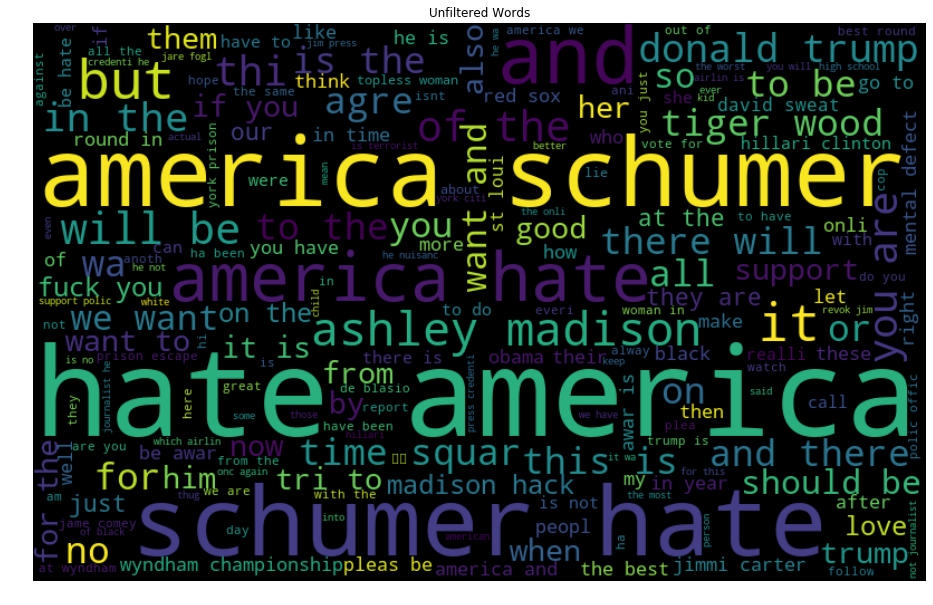

In [536]:
all_words = ' '.join([text for text in user_tweet_bag])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=200, stopwords = ['hey', 'lol', '[][]', 'cc', 'anyon', 'say', 'etc']).generate(all_words)

plt.figure(figsize=(16, 16))
plt.imshow(wordcloud, interpolation="bilinear", cmap = 'inferno')
plt.axis('off')
plt.title('Unfiltered Words')
plt.show()

In [538]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_1, tf_lda, tf_vectorizer, mds='tsne')
panel
## x-axis --> two components that capture most ammount of variance!

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                 x           y  topics  cluster       Freq
topic                                                     
1      -632.045471 -384.325073       1        1  99.667423
2     -1209.665405  212.164124       2        1   0.213789
0     -1437.453247 -586.322510       3        1   0.118787, topic_info=     Category         Freq     Term        Total  loglift  logprob
term                                                              
5626  Default  2057.000000    trump  2057.000000  30.0000  30.0000
323   Default  1130.000000   ashley  1130.000000  29.0000  29.0000
3247  Default  1117.000000  madison  1117.000000  28.0000  28.0000
6014  Default   925.000000     wood   925.000000  27.0000  27.0000
1627  Default   763.000000   donald   763.000000  26.0000  26.0000
5499  Default   706.000000    tiger   706.000000  25.0000  25.0000
5872  Default  1155.000000       wa  1155.000000  24.0000  24.0000
6092  Default   886.000000     york   886.000000  23.0000  23.0000
6006  Default   803.000000    woman   803.000000  22.0000  22.0000
2409  Default  1027.000000       ha  1027.000000  21.0000  21.0000
4901  Default   720.000000    shoot   720.000000  20.0000  20.0000
3263  Default   752.000000     make   752.000000  19.0000  19.0000
6068  Default   574.000000  wyndham   574.000000  18.0000  18.0000
3977  Default  1001.000000    peopl  1001.000000  17.0000  17.0000
5141  Default   661.000000    squar   661.000000  16.0000  16.0000
4170  Default   556.000000   presid   556.000000  15.0000  15.0000
1791  Default   476.000000    email   476.000000  14.0000  14.0000
5505  Default   828.000000     time   828.000000  13.0000  13.0000
2950  Default  1291.000000     just  1291.000000  12.0000  12.0000
2991  Default   916.000000     kill   916.000000  11.0000  11.0000
580   Default  1312.000000    black  1312.000000  10.0000  10.0000
4722  Default   646.000000      say   646.000000   9.0000   9.0000
1368  Default   520.000000      day   520.000000   8.0000   8.0000
5540  Default   567.000000  topless   567.000000   7.0000   7.0000
4094  Default   844.000000    polic   844.000000   6.0000   6.0000
6082  Default   659.000000     year   659.000000   5.0000   5.0000
4198  Default   517.000000   prison   517.000000   4.0000   4.0000
4632  Default   400.000000    round   400.000000   3.0000   3.0000
528   Default   646.000000     best   646.000000   2.0000   2.0000
5175  Default   531.000000    state   531.000000   1.0000   1.0000
...       ...          ...      ...          ...      ...      ...
4135   Topic3     0.099791     pour    14.190541   1.7783  -7.9342
5626   Topic3     0.383551    trump  2057.693559  -1.8520  -6.5878
644    Topic3     0.164098   border    92.137102   0.4050  -7.4368
3247   Topic3     0.312079  madison  1117.604950  -1.4479  -6.7940
323    Topic3     0.287505   ashley  1130.130326  -1.5410  -6.8760
2393   Topic3     0.111530    guard    24.038217   1.3625  -7.8230
6014   Topic3     0.217462     wood   925.281648  -1.6202  -7.1553
1627   Topic3     0.201443   donald   763.724638  -1.5049  -7.2318
6011   Topic3     0.109649      won    32.193058   1.0534  -7.8400
4662   Topic3     0.113108  russian    41.974061   0.8191  -7.8089
5499   Topic3     0.176295    tiger   706.618481  -1.5605  -7.3651
3078   Topic3     0.137819       le   165.162441  -0.3532  -7.6113
4901   Topic3     0.164484    shoot   720.332546  -1.6491  -7.4345
6092   Topic3     0.162811     york   886.527476  -1.8669  -7.4447
5365   Topic3     0.136017     talk   183.506489  -0.4716  -7.6245
5540   Topic3     0.150297  topless   567.162693  -1.5002  -7.5247
3977   Topic3     0.156903    peopl  1001.602978  -2.0259  -7.4817
3263   Topic3     0.151023     make   752.334843  -1.7779  -7.5198
580    Topic3     0.158000    black  1312.455933  -2.2892  -7.4747
1368   Topic3     0.145257      day   520.376485  -1.4482  -7.5588
2409   Topic3     0.148421       ha  1027.698548  -2.1072  -7.5372
5505   Topic3     0.141796     time   828.83

## Interpretation of this plot
This visualization provides a **global view of the topics** and **how they differ** from each other while at the same time allowing for a deep inspection of the terms most highly associated with each individual topic. 

Visualizations of topic model are usually a challenge since we are operating in multidimentional space. Documents (all tweets per user) are modeled as a mixture (probability distribution) of topics and topics themselves are modeled as distributions over terms (words/n-grams).

This visualization answers following questions: 

1. What is the meaning of each topic? 
* Answer to this questions can be derived from the right panel of this visualization: List of top 

Left part of visualization anwers following qiestions: We are observing topics as circles in two-dimensional plane whose centers are determined by computing the distance between topics that are scaled to project the intertopic distances onto two dimentions. 
2. How prevalent is each topic?
3. How do the topics relate to each other?
We are observing topics as circles in two-dimensional plane whose centers are determined by computing the distance between topics that are scaled to project the intertopic distances onto two dimentions.
** Area ** of the circle represents prevalence of the topic. The larger the area the more the prevalence.   


## Attempt to use Gensim for my LDA model

In [29]:
import gensim
import gensim.corpora as corpora

from gensim.models import CoherenceModel

import pyLDAvis.gensim


# # Enable logging for gensim - optional
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#### VVV DIDN'T USE

In [30]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(user_tweet_bow, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[user_tweet_bow], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
# print(trigram_mod[bigram_mod[user_tweet_bow[0]]])

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form Bigrams
data_words_bigrams = make_bigrams(user_tweet_bow)

data_words_trigrams = make_trigrams(user_tweet_bow)



### Cohesiveness of the 2 and three gram model:
For 2 grams cohesiveness was 0.55, for 3 grams model cohesiveness score was: 

In [31]:
# Create Dictionary
id2word = corpora.Dictionary(user_tweet_bow) # user_tweet_bow

# Create Corpus
texts = user_tweet_bow


# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 3), (4, 2), (5, 1), (6, 1), (7, 2), (8, 2), (9, 1), (10, 1), (11, 2), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 3), (27, 1), (28, 1), (29, 15), (30, 1), (31, 1), (32, 2), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 2), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 7), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 4), (56, 1), (57, 1), (58, 2), (59, 4), (60, 1), (61, 1), (62, 1), (63, 1), (64, 2), (65, 1), (66, 2), (67, 2), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 4), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2), (81, 1), (82, 3), (83, 2), (84, 3), (85, 1), (86, 1), (87, 4), (88, 1), (89, 2), (90, 2), (91, 3), (92, 1), (93, 1), (94, 1), (95, 8), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 2), (108, 1), (109, 1), (110, 1

In [32]:
id2word[0]

'acr'

In [33]:
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [46]:
### Building LDA GENSIM Model

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=9, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [47]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.017*"peopl" + 0.012*"presid" + 0.009*"countri" + 0.009*"make" + '
  '0.007*"like" + 0.007*"come" + 0.007*"let" + 0.007*"peac" + 0.006*"lie" + '
  '0.006*"life"'),
 (1,
  '0.016*"allah" + 0.012*"ibn" + 0.009*"done" + 0.007*"follow" + 0.006*"among" '
  '+ 0.006*"hallmark" + 0.006*"abi" + 0.006*"recit" + 0.006*"mention" + '
  '0.006*"pieti"'),
 (2,
  '0.026*"في" + 0.014*"من" + 0.011*"على" + 0.006*"و" + 0.005*"إلى" + '
  '0.004*"عن" + 0.004*"السوري" + 0.003*"مع" + 0.003*"؟" + 0.003*"السورية"'),
 (3,
  '0.009*"shoot" + 0.009*"polic" + 0.009*"trump" + 0.008*"time" + '
  '0.007*"clinton" + 0.007*"woman" + 0.007*"kill" + 0.007*"york" + '
  '0.007*"email" + 0.006*"protest"'),
 (4,
  '0.018*"ashley" + 0.017*"madison" + 0.016*"wood" + 0.012*"trump" + '
  '0.012*"tiger" + 0.010*"york" + 0.010*"donald" + 0.010*"time" + '
  '0.009*"squar" + 0.009*"wyndham"'),
 (5,
  '0.008*"si̇zə" + 0.004*"azeri" + 0.004*"siz" + 0.003*"var" + 0.003*"bir" + '
  '0.002*"siktir" + 0.002*"gözəl" + 0.002*"si̇zi

In [48]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=user_tweet_bow, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)   


Perplexity:  -7.606371484106673

Coherence Score:  0.706707423791579


In [49]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.207211 -0.041700       1        1  51.922249
4     -0.233271  0.039744       2        1  16.512089
3     -0.239034  0.038613       3        1  15.803758
0     -0.190690 -0.091119       4        1  12.379707
2      0.174463  0.132953       5        1   2.427204
8      0.214706 -0.333552       6        1   0.584780
5      0.164325  0.081961       7        1   0.206096
1      0.159499  0.097659       8        1   0.145142
7      0.157213  0.075441       9        1   0.018976, topic_info=      Category         Freq        Term        Total  loglift  logprob
term                                                                  
1716   Default  9434.000000     america  9434.000000  30.0000  30.0000
1812   Default  9393.000000        hate  9393.000000  29.0000  29.0000
414    Default  5276.000000     schumer  5276.000000  28.0000  28.0000
29     Default   964.000000      ashley   964.000000  27.0000  27.0000
345    Default  1132.000000       peopl  1132.000000  26.0000  26.0000
293    Default   945.000000     madison   945.000000  25.0000  25.0000
544    Default   783.000000        wood   783.000000  24.0000  24.0000
48     Default   656.000000        best   656.000000  23.0000  23.0000
555    Default   731.000000        york   731.000000  22.0000  22.0000
1153   Default   177.000000        done   177.000000  21.0000  21.0000
489    Default   611.000000       tiger   611.000000  20.0000  20.0000
504    Default  1846.000000       trump  1846.000000  19.0000  19.0000
1162   Default   277.000000        said   277.000000  18.0000  18.0000
490    Default   778.000000        time   778.000000  17.0000  17.0000
6361   Default  1193.000000         hey  1193.000000  16.0000  16.0000
454    Default   511.000000       state   511.000000  15.0000  15.0000
368    Default   718.000000      presid   718.000000  14.0000  14.0000
448    Default   628.000000       squar   628.000000  13.0000  13.0000
718    Default   203.000000      follow   203.000000  12.0000  12.0000
146    Default   611.000000      donald   611.000000  11.0000  11.0000
91     Default   389.000000        citi   389.000000  10.0000  10.0000
134    Default   315.000000       death   315.000000   9.0000   9.0000
425    Default   597.000000       shoot   597.000000   8.0000   8.0000
360    Default   857.000000       polic   857.000000   7.0000   7.0000
1241   Default   384.000000     countri   384.000000   6.0000   6.0000
551    Default   498.000000     wyndham   498.000000   5.0000   5.0000
812    Default   371.000000        love   371.000000   4.0000   4.0000
814    Default   727.000000        make   727.000000   3.0000   3.0000
5275   Default   165.000000          في   165.000000   2.0000   2.0000
93     Default   229.000000       claim   229.000000   1.0000   1.0000
...        ...          ...         ...          ...      ...      ...
10039   Topic9     0.018578     austria     0.674039   4.9784  -7.9055
1174    Topic9     0.014214       brows     0.669644   4.7172  -8.1732
9002    Topic9     0.014027      swtamp     0.669546   4.7041  -8.1864
9000    Topic9     0.014027     ramadan     0.669546   4.7041  -8.1864
8999    Topic9     0.014027     mubarak     0.669546   4.7041  -8.1864
8998    Topic9     0.014027  flairboard     0.669546   4.7041  -8.1864
8996    Topic9     0.014026     donвђ™t     0.669546   4.7041  -8.1865
6989    Topic9     0.013964      fragil     0.669506   4.6997  -8.1909
6988    Topic9     0.013964      awwwww     0.669506   4.6997  -8.1909
1178    Topic9     0.014214         isp     0.686899   4.6918  -8.1732
3411    Topic9     0.033020     highway     2.458467   4.2596  -7.3303
2554    Topic9     0.005334       moham     0.676159   3.7274  -9.1533
9014    Topic9     0.035812     hungari     5.114120   3.6083  -7.2491
9708    Topic9     0.003096       bitin     0.671527   3.1901  -9.6975
9709    Topic9     0.00309

In [50]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [56]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=user_tweet_bow, start=3, limit=40, step=2)

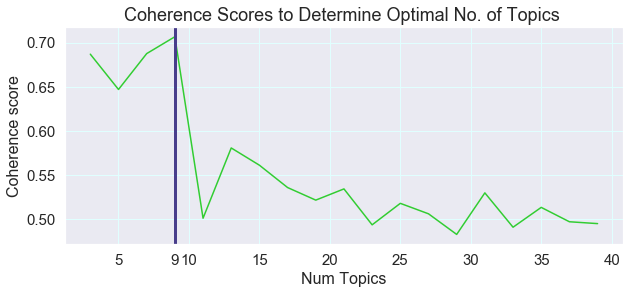

In [85]:
# Show graph
import seaborn as sns
limit=40; start=3; step=2;

x = range(start, limit, step)

plt.figure(figsize=(10,4))

sns.set_style("darkgrid")

plt.plot(x, coherence_values, c = 'limegreen')
plt.xlabel("Num Topics", fontsize = 16)
plt.ylabel("Coherence score", fontsize = 16)


plt.xticks((5, 9, 10, 15, 20, 25, 30, 35, 40), fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid(c = 'lightcyan')

plt.axvline(x=9, c = 'darkslateblue', linewidth = 3.0)

plt.title('Coherence Scores to Determine Optimal No. of Topics ', fontsize = 18)
plt.show()



In [92]:
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=15))

[(0,
  '0.011*"я" + 0.011*"peopl" + 0.011*"не" + 0.010*"presid" + 0.009*"и" + '
  '0.008*"в" + 0.007*"на" + 0.007*"с" + 0.006*"peac" + 0.006*"zimbabw" + '
  '0.006*"countri" + 0.006*"ed" + 0.004*"zimbabwean" + 0.004*"меня" + '
  '0.004*"так"'),
 (1,
  '0.014*"allah" + 0.011*"ibn" + 0.009*"done" + 0.007*"difficult" + '
  '0.007*"cure" + 0.007*"follow" + 0.006*"pleas" + 0.006*"billionair" + '
  '0.006*"among" + 0.006*"mention" + 0.006*"make" + 0.006*"turn" + 0.006*"cri" '
  '+ 0.006*"hallmark" + 0.006*"fear"'),
 (2,
  '0.027*"في" + 0.015*"من" + 0.013*"condom" + 0.012*"على" + 0.008*"deflect" + '
  '0.006*"و" + 0.005*"إلى" + 0.004*"عن" + 0.004*"السوري" + 0.004*"مع" + '
  '0.003*"؟" + 0.003*"السورية" + 0.003*"الأحداث" + 0.003*"موجز" + 0.003*"بين"'),
 (3,
  '0.011*"polic" + 0.007*"u" + 0.007*"arrest" + 0.006*"agre" + '
  '0.005*"terrorist" + 0.005*"say" + 0.005*"support" + 0.005*"call" + '
  '0.005*"child" + 0.004*"like" + 0.004*"kill" + 0.004*"may" + 0.004*"year" + '
  '0.004*"law" + 0.004*

In [93]:
arab_words = ['فيمن','على' ,'على' ,'إلى']  ### Lesson Learned, word cloud doesn't speak arabic

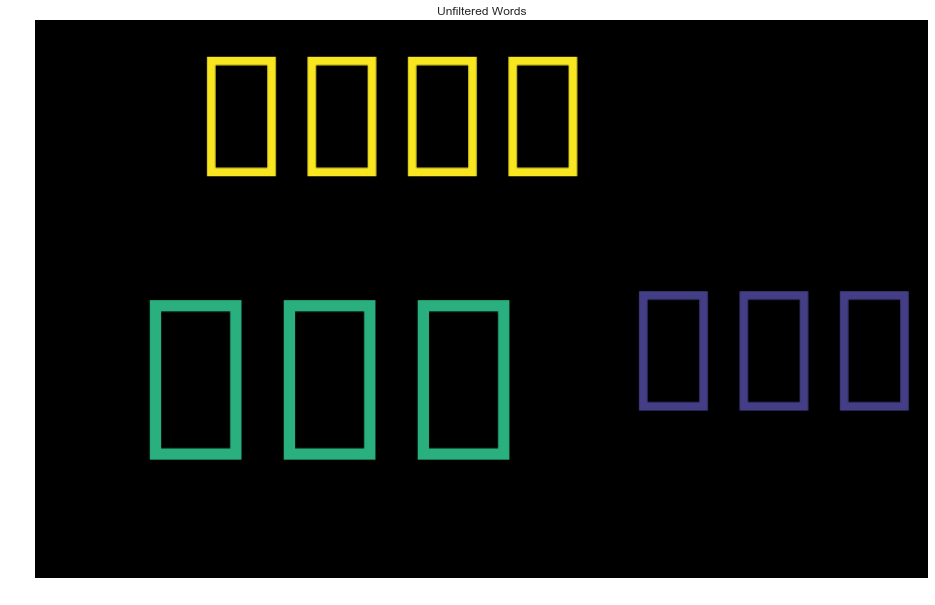

In [91]:
all_words = ' '.join([text for text in arab_words])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=200, stopwords = ['hey', 'lol', '[][]', 'cc', 'anyon', 'say', 'etc']).generate(all_words)

plt.figure(figsize=(16, 16))
plt.imshow(wordcloud, interpolation="bilinear", cmap = 'inferno')
plt.axis('off')
plt.title('Unfiltered Words')
plt.show()

In [94]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

TypeError: '<' not supported between instances of 'int' and 'tuple'